# Completion Rate

In [16]:
import numpy as np


# Additionally, suppress NumPy warnings
np.seterr(all="ignore")  # This will suppress warnings from NumPy operations

import pandas as pd
import re
import rich


def _extract_learning_objective(path: str) -> str:
    """
    Extract the learning objective from the path
    """
    # The path is in the format of responses_assessment_level2_1.1.csv
    # We want to extract the chapter number from the file name, i.e. 1.1 in this case
    learning_objective_pattern = re.compile(
        r".*responses_assessment_level2_(\d+\.\d+)\.csv"
    )

    # Find column from data.columns that match the above pattern and extract out the chapter
    match = learning_objective_pattern.match(path)
    learning_objective = match.group(1)
    return learning_objective


def process_data(path: str) -> dict[str, float]:
    """
    Process the data from the file specified by the path.
    Return a dict with the following keys:
    - `learnin`: the chapter number.
    - `completion_rate_0-70_pct`: the percentage of students who have completed 0-70% percent of the questions.
    - `completion_rate_70-90_pct`: the percentage of students who have completed 70-90% percent of the questions.
    - `completion_rate_90-100_pct`: the percentage of students who have completed 90-100% percent of the questions.
    - `unique_student_count`: the number of unique students who have completed at least one question.
    - `unique_question_count`: the number of unique questions that have been completed by at least one student.
    """

    data = pd.read_csv(path, index_col=0, low_memory=False)

    # Reset the index to make id_p a regular column
    data = data.reset_index()

    learning_objective = _extract_learning_objective(path)

    # rich.print(
    #     f"[yellow bold]Processing learning objective: [/yellow bold]{learning_objective}"
    # )

    if len(data) == 0:
        rich.print("[red bold]No data found, skipped[/red bold]")
        return

    unique_student_count = len(data["student_id"].unique())
    unique_question_count = len(data["id_p"].unique())

    # Group by student_id and count unique questions per student
    questions_per_student = data.groupby("student_id")["id_p"].nunique()

    # Calculate completion rate as percentage of total unique questions
    completion_rates = questions_per_student / unique_question_count * 100

    # Calculate percentage of students in each completion rate bucket
    completion_buckets = pd.cut(
        completion_rates, bins=[0, 70, 90, 100], labels=["0-70", "70-90", "90-100"]
    )
    bucket_percentages = completion_buckets.value_counts(normalize=True) * 100

    # keep two decimal places
    bucket_percentages = bucket_percentages.round(2)

    # Create result dictionary
    result = {
        "learning_objective": learning_objective,
        "completion_rate_0-70_pct": bucket_percentages.get("0-70", 0),
        "completion_rate_70-90_pct": bucket_percentages.get("70-90", 0),
        "completion_rate_90-100_pct": bucket_percentages.get("90-100", 0),
        "unique_student_count": unique_student_count,
        "unique_question_count": unique_question_count,
    }

    return result

In [17]:
process_data("../data/csv_oct15_24/responses_assessment_level2_1.1.csv")

{'learning_objective': '1.1',
 'completion_rate_0-70_pct': 74.47,
 'completion_rate_70-90_pct': 16.94,
 'completion_rate_90-100_pct': 8.6,
 'unique_student_count': 1966,
 'unique_question_count': 46}

In [33]:
import glob
from tqdm.notebook import tqdm

outputs = []

# Process all the data
input_files = glob.glob("../data/csv_oct15_24/*.csv")
input_files = sorted(input_files)

progress_bar = tqdm(input_files)
for input_file in progress_bar:
    progress_bar.set_description(f"Processing learning objective {learning_objective}")
    learning_objective = _extract_learning_objective(input_file)
    result = process_data(input_file)
    outputs.append(result)

pd.DataFrame(outputs).to_csv("completion_rate.csv", index=False)

  0%|          | 0/15 [00:00<?, ?it/s]

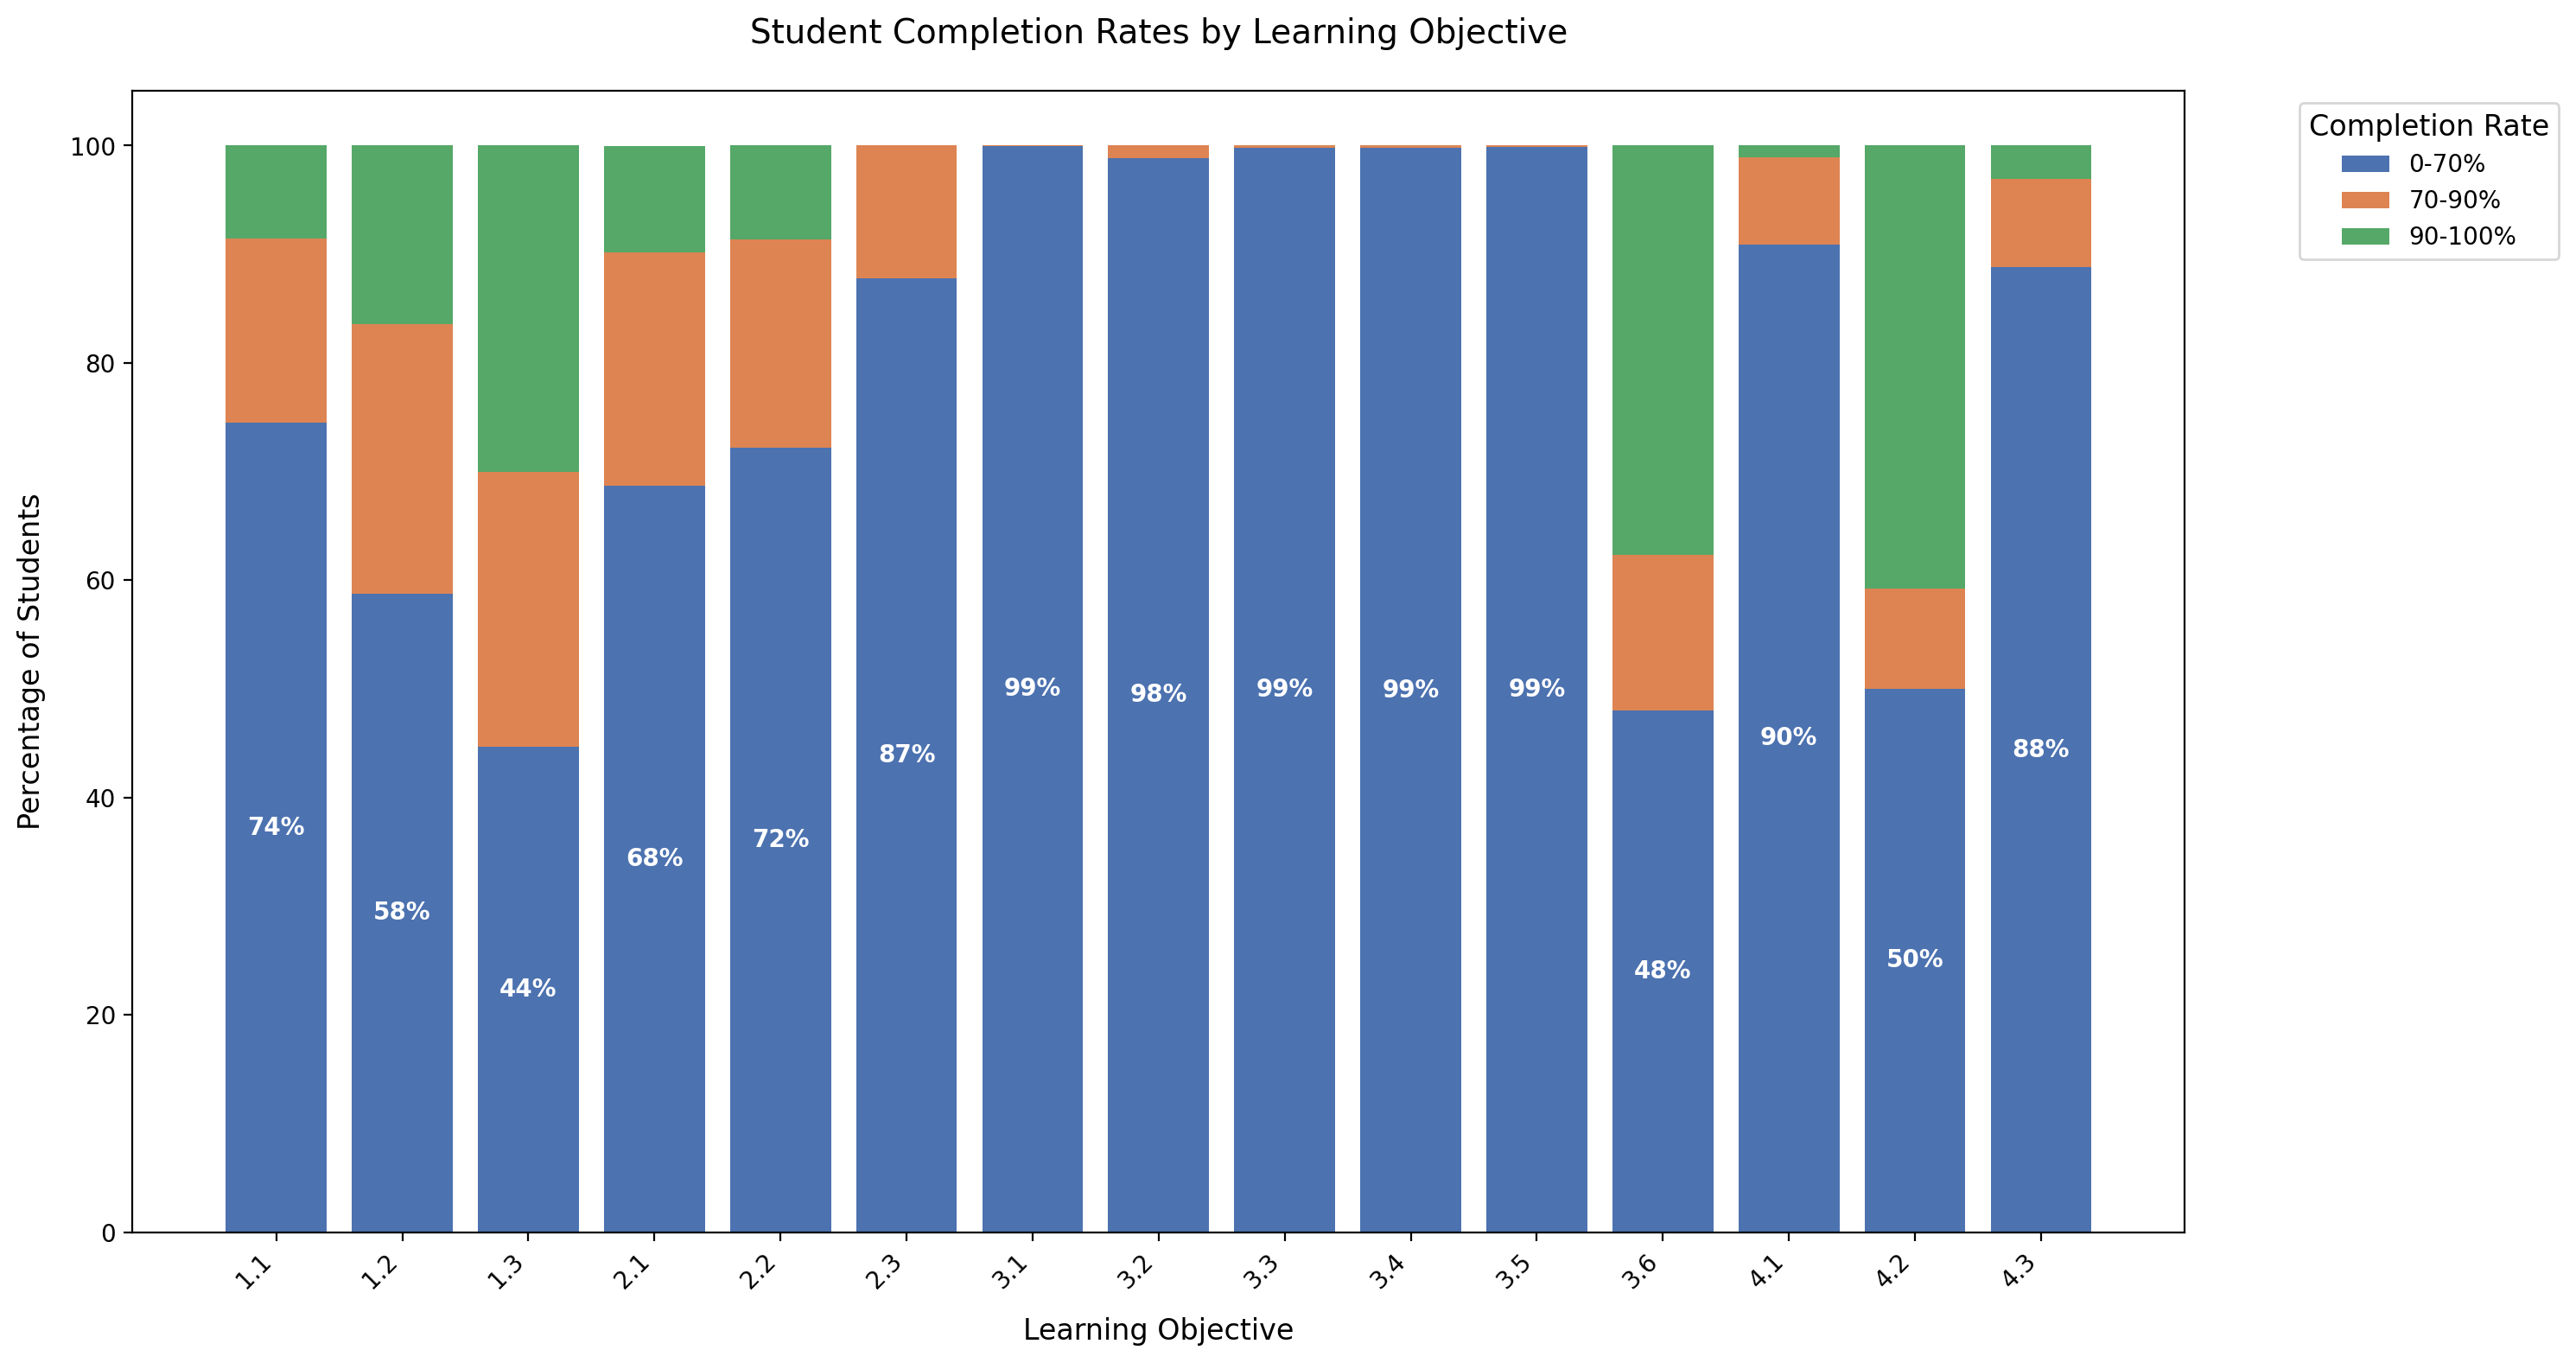

In [46]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Enable retina display
%config InlineBackend.figure_format = 'retina'


# Read the results
df = pd.read_csv("completion_rate.csv")

# Set the style
sns.set_palette("deep")

# Create figure
plt.figure(figsize=(15, 8))

# Create the stacked bars
ax = plt.gca()
bottom_vals = np.zeros(len(df))

# Use plt.bar instead of sns.barplot for stacked bars
for column, label in [
    ("completion_rate_0-70_pct", "0-70%"),
    ("completion_rate_70-90_pct", "70-90%"),
    ("completion_rate_90-100_pct", "90-100%"),
]:
    plt.bar(range(len(df)), df[column], bottom=bottom_vals, label=label, width=0.8)
    bottom_vals += df[column]

# Set x-axis ticks and labels
plt.xticks(range(len(df)), df["learning_objective"], rotation=45, ha="right")

# Customize the plot
plt.title("Student Completion Rates by Learning Objective", fontsize=14, pad=20)
plt.xlabel("Learning Objective", fontsize=12, labelpad=10)
plt.ylabel("Percentage of Students", fontsize=12, labelpad=10)

# Customize legend
plt.legend(
    title="Completion Rate",
    title_fontsize=12,
    bbox_to_anchor=(1.05, 1),
    loc="upper left",
    frameon=True,
)

# Add percentage labels on bars
for i in range(len(df)):
    percentage = df["completion_rate_0-70_pct"].iloc[i]
    if percentage > 5:
        plt.text(
            i,
            percentage / 2,
            f"{int(percentage)}%",
            ha="center",
            va="center",
            color="white",
            fontweight="bold",
        ) 

# Adjust layout and display
plt.tight_layout()
plt.show()